# <h1 align="center">Automated Sentiment Analysis: A Case Study on movie reviews</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively.
<a href="https://imgur.com/FfdEBRz"><img src="https://i.imgur.com/FfdEBRzm.png" title="source: imgur.com" align="right"></a>
- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- Contains 25000 positive and 25000 negative reviews
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)


## <h2 align = "center" >Dependecies</h2>

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk

import warnings
warnings.filterwarnings('ignore')
import os

import gc
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# re is used for cleaning the dataset 

import re


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# callbacks are important here as sometimes you get the best accuracy earlies and then it 
# goes down so as to stop the training there you need to use them


from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## <h2> <center>Preliminary Data Exploration</center></h2>

In [10]:
# for importing data 

movies = pd.read_csv('/Users/mohitkapoor/Downloads/New code/imdb_data.csv')
movies.sample(7)

,review,sentiment
35246,The story has little to do with Jack London's ...,negative
42974,Please don't waste your money on this sorry ex...,negative
47259,This film seemed way too long even at only 75 ...,negative
28023,Trey's favourite from the first run of Season ...,positive
49945,"This picture started out with good intentions,...",negative
20,After the success of Die Hard and it's sequels...,positive
15192,It is hard to imagine anyone making a Tom Crui...,negative


In [11]:
movies.dtypes

review       object
sentiment    object
dtype: object

In [12]:
movies.isna().sum()

review       0
sentiment    0
dtype: int64

In [13]:
#sentiment count
movies['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

> No missing values in the dataset

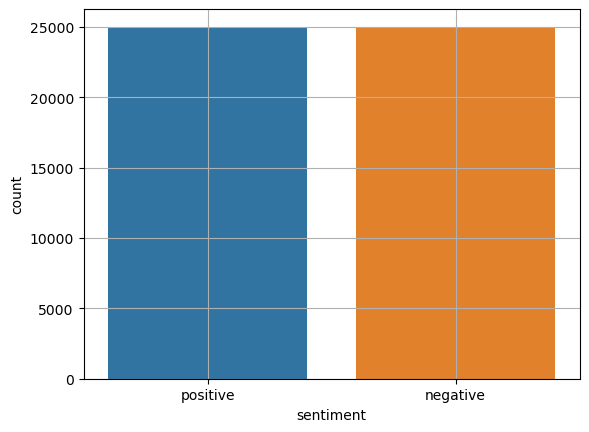

In [14]:
sns.countplot(x=movies['sentiment'])
plt.grid()

In [15]:
sentences=movies['review']
le=LabelEncoder()
movies['sentiment']= le.fit_transform(movies['sentiment'])

In [16]:
# Looking at sample review
sample = 777
sample_review = movies.review.iloc[sample]
print(sample_review)
print("\nAssigned sentiment: ", movies.sentiment.iloc[sample])

It's amazing that such a cliche-ridden yuppie angst film actually got made in the first place. The characters are so weak, and the acting so uninspired, that it's impossible to care about any of them-- especially Brooke Shields. The temptation to fast forward through the slow parts is almost irresistible. If you like this genre, you'd be better off renting "Singles," or "Bodies, Rest & Motion."

Assigned sentiment:  0


> **Contains html tags, accented characters, punctutations and emoticons, numbers... etc., Should deal with them in the preprocessing step**

In [7]:
# Cateogrize positive and negative as 1 and 0 respectively
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
movies['sentiment'] = label_encoder.fit_transform(movies['sentiment'])
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

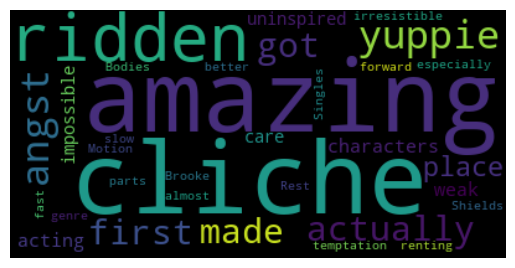

In [9]:
from wordcloud import WordCloud, STOPWORDS

my_stop_wrods = set(STOPWORDS)
my_stop_words = STOPWORDS.update(['movie', 'movies', 'film', 'films', 'br'])

my_cloud = WordCloud(stopwords=my_stop_words).generate(sample_review)
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

## <h2> <center>Preprocessing</center></h2>

In [10]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import os
import multiprocessing

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohitkapoor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohitkapoor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
!pip install langdetect

In [12]:
# Looking for languages
from langdetect import detect_langs

languages =[]
# pick 500 random reviews out of the dataset as langauge detection on every review is not feasible
samples = np.random.choice(len(movies.review), size = 100, replace = False)
# Loop over the rows of the dataset and append  
for row in samples:
    languages.append(detect_langs(movies.review[row]))

# Clean the list by splitting     
languages = [str(lang).split(':')[0][1:] for lang in languages]

print("Unique languages in the reviews: ", np.unique(languages))

Unique languages in the reviews:  ['en']


> **We can be fairly certain all the reviews are in english. No need to consider other languages while preprocessing**

In [13]:
# Finding out the most frequent words in our specific dataset to add stopwords customized to the movie reviews domain
from collections import Counter

top_N = 50

stopwords = nltk.corpus.stopwords.words('english')
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (movies.review
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DataFrame out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [14]:
rslt.transpose()

Word,',/><br,.,movie,",",/>,film,one,like,(,...,love,best,seen,characters,.<br,character,movies,ever,still,films
Frequency,154326,100980,62875,61492,61228,56642,55086,44983,37281,25317,...,10748,10743,10611,10599,10474,10386,10349,10218,9778,9578


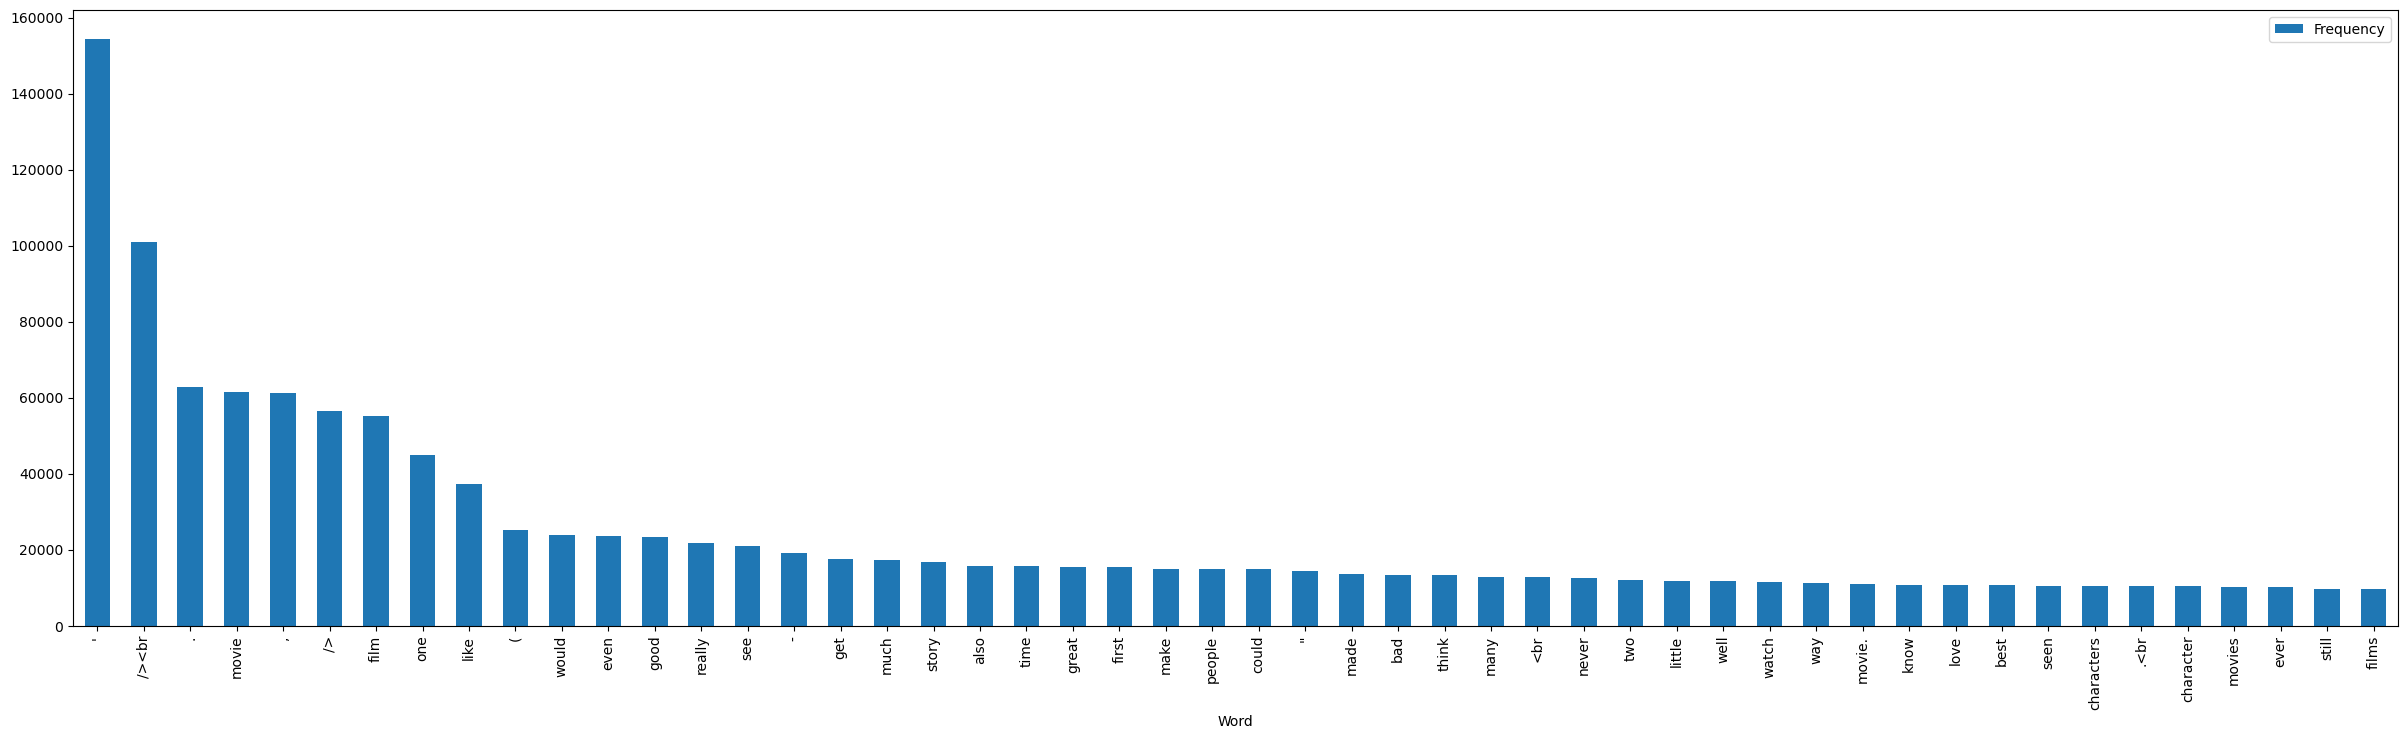

In [15]:
# plot
rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

### <h2> <center>Helper functions to aid in preprocessing the text </center></h2>

In [16]:
def sample_reviews(samples = 7):
    for review in movies['review'].sample(samples):
        print(review)
        print("")

sample_reviews()

This is my favorite game for the Nintendo 64 platform. I've played many different first-person shooters, and I've never really liked any of them much, but this game has a certain something that I can't put my finger on that makes it an amazing amount of fun. Maybe it's the extraordinary detail put into the game. Maybe it's the fluid movement of the characters. Maybe it's the gadgets and weapons. Maybe it's the suave character of James Bond. Whatever it is, this game never seems to get old no matter how many times I've played it.

If Jacqueline McKenzie and John Lynch weren't such talented actors this film would probably be even worse than it actually is.The story of two mentally disturbed people who fall in love and have a baby is an interesting one,and well worth exploring.However on the negative side,the plot becomes increasingly over the top as the story progresses,and the music choices more and more bizarre,so that by the end I found myself laughing when I know the director intende

In [17]:
def strip_html_tags(review_text):
    soup = BeautifulSoup(review_text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text
movies['review'] = movies['review'].apply(strip_html_tags)
sample_reviews()

Another comedy about a plucky little country struggling through the jungle of the modern (for the forties) global world with only native wit and pluck to guide them, this is a fine entry in the Ealing cannon. Terry-Thomas sparkles as usual in the lead, as a feckless ministry man led to the brink of disaster when a nation he is supposedly in charge of starts attracting the interest of the world, Ian Bannen makes a great romantic lead, Peter Sellers puts in one of his quieter performances as a corrupt politico and the uber-suave John Le Mesurier plays against type as a rugged revolutionary leader. Lots of fun is had by all, especially the viewer; perhaps not in the very top echelon of Ealing classics, but pretty high up.

I can't believe I rarely ever see this title mentioned by all you eighties horror freaks and I definitely won't be joining all my fellow reviewers here in saying that 'Bloody Birthday' is awful viewing. On the contrary, I enjoyed it very much and I was pleasantly surpri

In [18]:
import unicodedata

def replace_accented_chars(review_text):
    unaccented_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return unaccented_text
movies['review'] = movies['review'].apply(replace_accented_chars)
sample_reviews()

I was actually planning to see this movie when I noticed it in my TV guide but after about 5 minutes decided time is definitely more precious than "Who's That Girl" could ever be worth. Describing how bad Madonna's acting looks like is impossible and the end result is one of the most annoying characters ever captured on film. This crap is an insult to movies and intellect. I almost never! rate a movie I don't see from start to finish, but in this case the former is impossible. 2/10

It's hard to say which comes out on top, James Cagney's charm and energy or the mouth- opening excesses of Busby Berkeley's three grand showstoppers at the close. I give it a tie, with Footlight Parade one of the funniest and quickest of the early Thirties musicals. Although the movie clearly belongs to Cagney, Joan Blondell adds immeasurably to the good-natured story line. And what's the story line? It's about Chester Kent (Cagney) who produces musicals, and who now is just about out of business as the tal

In [19]:
def remove_special_characters(review_text):
    """ 
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review """
    review_text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_special_characters)
sample_reviews()

I have not read the novel  though I understand that this is somewhat different from it  the fact that I rather enjoyed this  coupled with the fact that this really is not my genre  leads me to the decision of not pursuing reading the book  Having not read a single word of Austen's writing  I really can't compare this to any of her work  What I can say is that almost every line of dialog in this is clever  witty  and well delivered  as well as the biggest source of comedy in this  This made me laugh out loud a lot  with perfect British and verbal material  Every acting performance is spot on  and Paltrow completely nails the role of a kind matchmaker  The characters are well written  credible and consistent  I did find a couple of them extremely irritating  however  and while I think that at least some of that was meant to be funny  it tended to get repeated excessively  and it honestly wasn't amusing the first time they appeared  The editing and cinematography are marvelous  and everyt

In [20]:
!pip install contractions
!pip install textsearch

In [21]:
import contractions
def expand_contractions(review_text):
    review_text = contractions.fix(review_text)
    return review_text
movies['review'] = movies['review'].apply(expand_contractions)
sample_reviews()

A film with very little positive to say for it Firstly it has zero pace and is positively lacking in any drama Besides being remarkably slow The Empty Acre seems dedicated to using the same stock footage again and again  I lost count of how many times I had seen  that  field at night or that bit of cracked earth It also has the fundamental flaw of thinking that if the audience do not know about things they will be gripped rather than just confused  So with no signs that there are any issues we suddenly find the marriage is not what it seems to be despite being given the impression that it is fine  We find Jacob is possibly the worst farmer in the universe as he seems to spend no time on the farm and also seems to have bought land with a wholly useless acre  Beth has a key to a warehouse of books? There are innumerable other questions some of which are resolved later in the movie  much later  in fact too late And on the point of the acre  Horror filmmakers note that large inanimate obje

In [22]:
# takes time ...
def strip_stops(review_text, is_lower_case=False, custom = True):
    tokens = word_tokenize(review_text)
    tokens = [token.strip() for token in tokens]
    if custom:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        # custom stopwords added from the most frequent words which are generic 
        # and might not relate to the sentiment of the review
        stop_words.update(['movie', 'film', 'one', 'would', 'even', 
                           'movies', 'films', 'cinema',
                           'character', 'show', "'", "!", 'like'])
    else:
        stop_words = set(nltk.corpus.stopwords.words('english'))
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

movies['review'] = movies['review'].apply(strip_stops)
sample_reviews()

suffers horrendously direction Julian Grant incompetent lead Steve Guttenberg putting solid effort win Bruce Willis look alike contest writing reckless Hollywood action thriller Sean Bean whose favorites David Fraser Kim Coates give decent performance definitely average 3 10 wonder Hollywood studios thought actually giving go ahead weak director Grant say Sean Bean thinking considering participating great GoldenEye Ronin Patriot Games

see everyone liked set long talky done main remained flat opaque first scene finally got Cusack eponymous hotel room wonder well going happen next hour keep engaged answer much John Cusack long drawn mental breakdown Maybe Cusack depth maybe freak thorough reworking everyday life maybe either better developed half baked themes loss faith tacked first place maybe made choice either psychological horror thrill ride horror fully embraced styles know know saw two horror buffs none us much liked Except disquieting episode hotel ledge alarming crazy lady hamme

In [23]:
# takes time ...
def snowball_stem(review_text):
    words = review_text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    review_text = " ".join(stemmed_words)
    return review_text

movies['review']=movies['review'].apply(snowball_stem)
sample_reviews()

confess sever disappoint version way compet version 1995 reason watch entir happi ciaran hind captain wentworth thought rupert penri jone look much captain imagin read book unfortun redeem qualiti rest un austen possibl miss elliot never run street bath done ladi time ann elliot book ladi digniti pain anachron worst although 3 import quot book entir inappropri moment warn know book yet anoth import part book either miss complet chang although version much shorter feel everyth rush littl care taken introduc charact disposit motiv import scene omit could possibl butcher final scene way ? disast far beauti photograph love austen wast time

video store brows dollar rental came upon littl gem know gut instic wow ever right stori center around two girl surviv school shoot girl alicia teenag rebl wit full attack anoth deanna anoth survivor surviv bullet head miracl thrown togeth fate slowli begin pain beauti display heal move hate amaz fall crack wow perform busi phillip erkia christensen men

> Notice the many ' and 's left as tokens which are not relevent

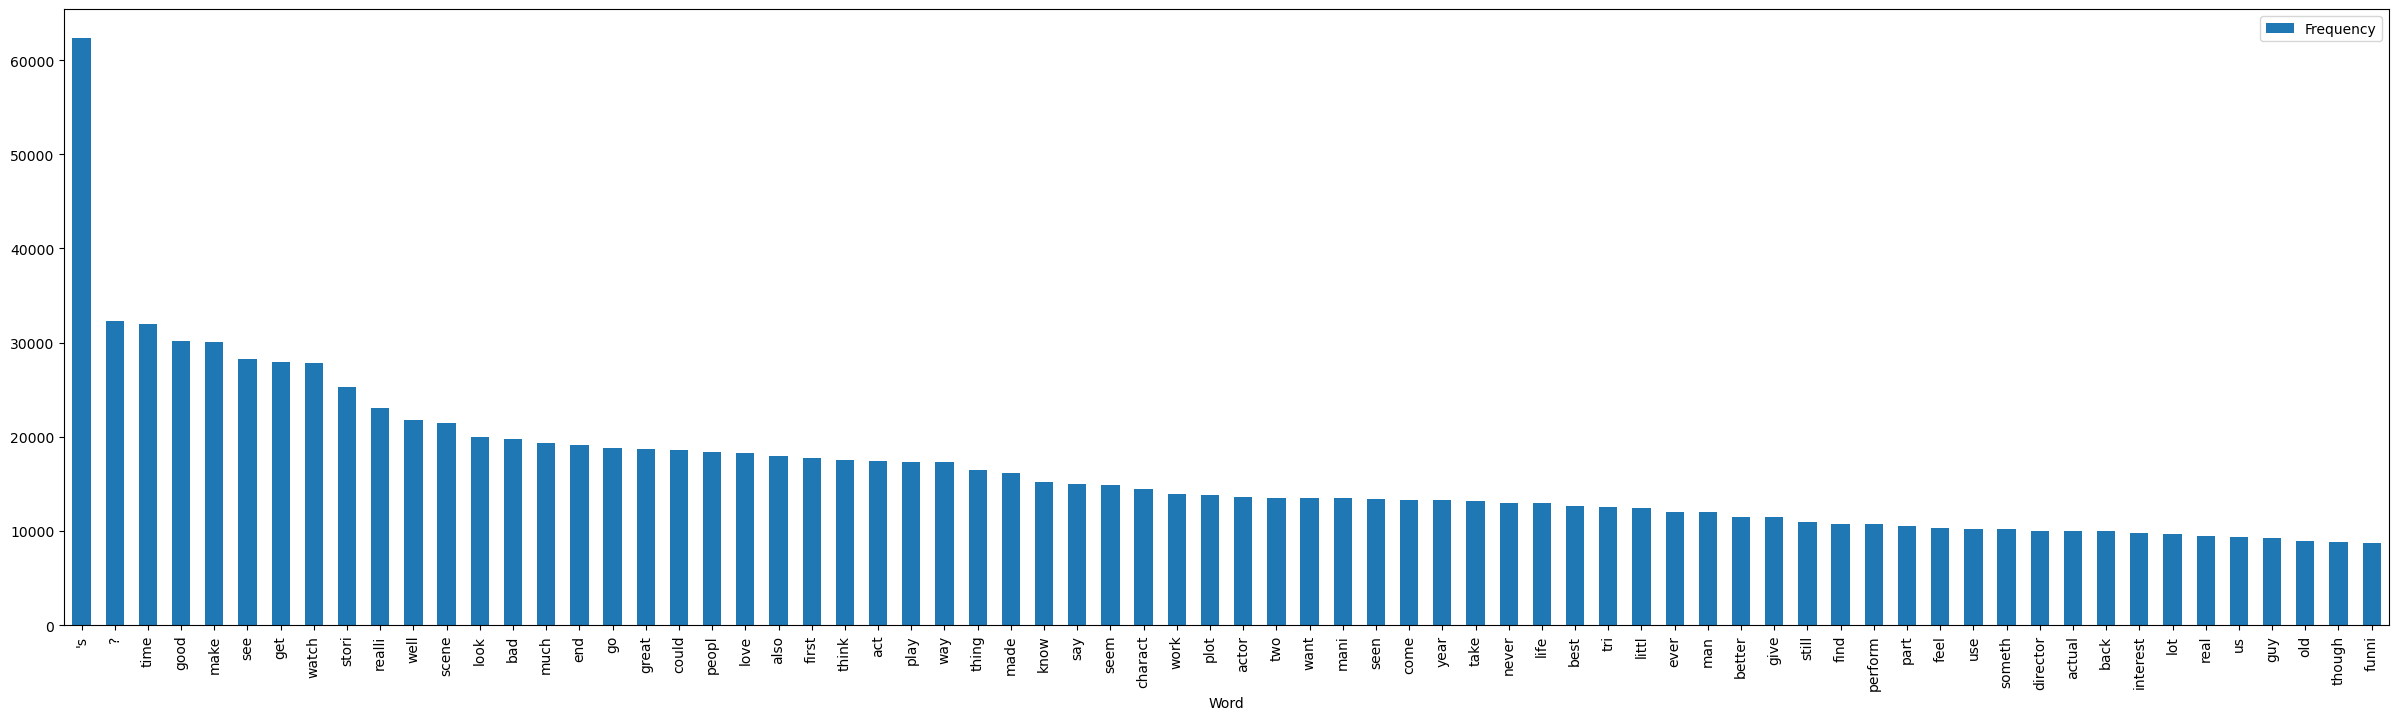

In [24]:
top_N = 70

words = (movies.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [25]:
rslt.transpose()

Word,'s,?,time,good,make,see,get,watch,stori,realli,...,actual,back,interest,lot,real,us,guy,old,though,funni
Frequency,62310,32336,31944,30180,30015,28233,27961,27868,25269,23089,...,10007,9947,9758,9720,9434,9383,9253,8933,8836,8764


In [26]:
def remove_apostrophe_s(review_text):
    review_text = re.sub(r"\'s", "", review_text)
    # review_text = re.sub(r"\s{2,}", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_apostrophe_s)
sample_reviews()

errol flynn best robin hood west fight militari red tape confeder indian carpetbagg busi crook singlehand great final heroic end forget ever reliabl de havilland ladi mari west never tri link stori fact real person work enjoy nobodi ever claim make documentari raoul walsh errol flynn co work

fabul actor beauti sceneri stark realiti elabor review comment get pictur howev squeamish realiti slaughter pig livestock order surviv also elinor randal stewart  homestead book read sever year ago reread sinc watch newli releas remast dvd tri buy video sever year final bought use video store went busi yippe dvd sale purchas amazon com cheap well worth watch end day

normal go way watch romant comedi mayb futur see return plot simpl secret public einstein guess happen first 15 minut relax let cast take world chemistri abound good guy win laugh good time love dvd order

mob boss vic moretti late great anthoni franciosa kill ladi cheat derek new chauffeur vietnam vet blame poor guy derek find jail c

In [27]:
movies.sample(7)

,review,sentiment
42249,fbi agent mulder sculli get assign probe myste...,1
1608,edit curs word superimpos blur give anoth fing...,0
44925,watch tv know much favorit actress watch reali...,1
13686,good news imdb bad compel regist make comment ...,0
8233,start show map explain radar quit awhil ever s...,0
21964,fulci time favorit italian splatter director a...,1
14229,bad memori childhood kid raini day school go r...,0


In [28]:
movies.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [29]:
movies.to_csv('/Users/mohitkapoor/Downloads/New code/cleaned_data.csv')

## <h2> <center>Visualize the data</center></h2>

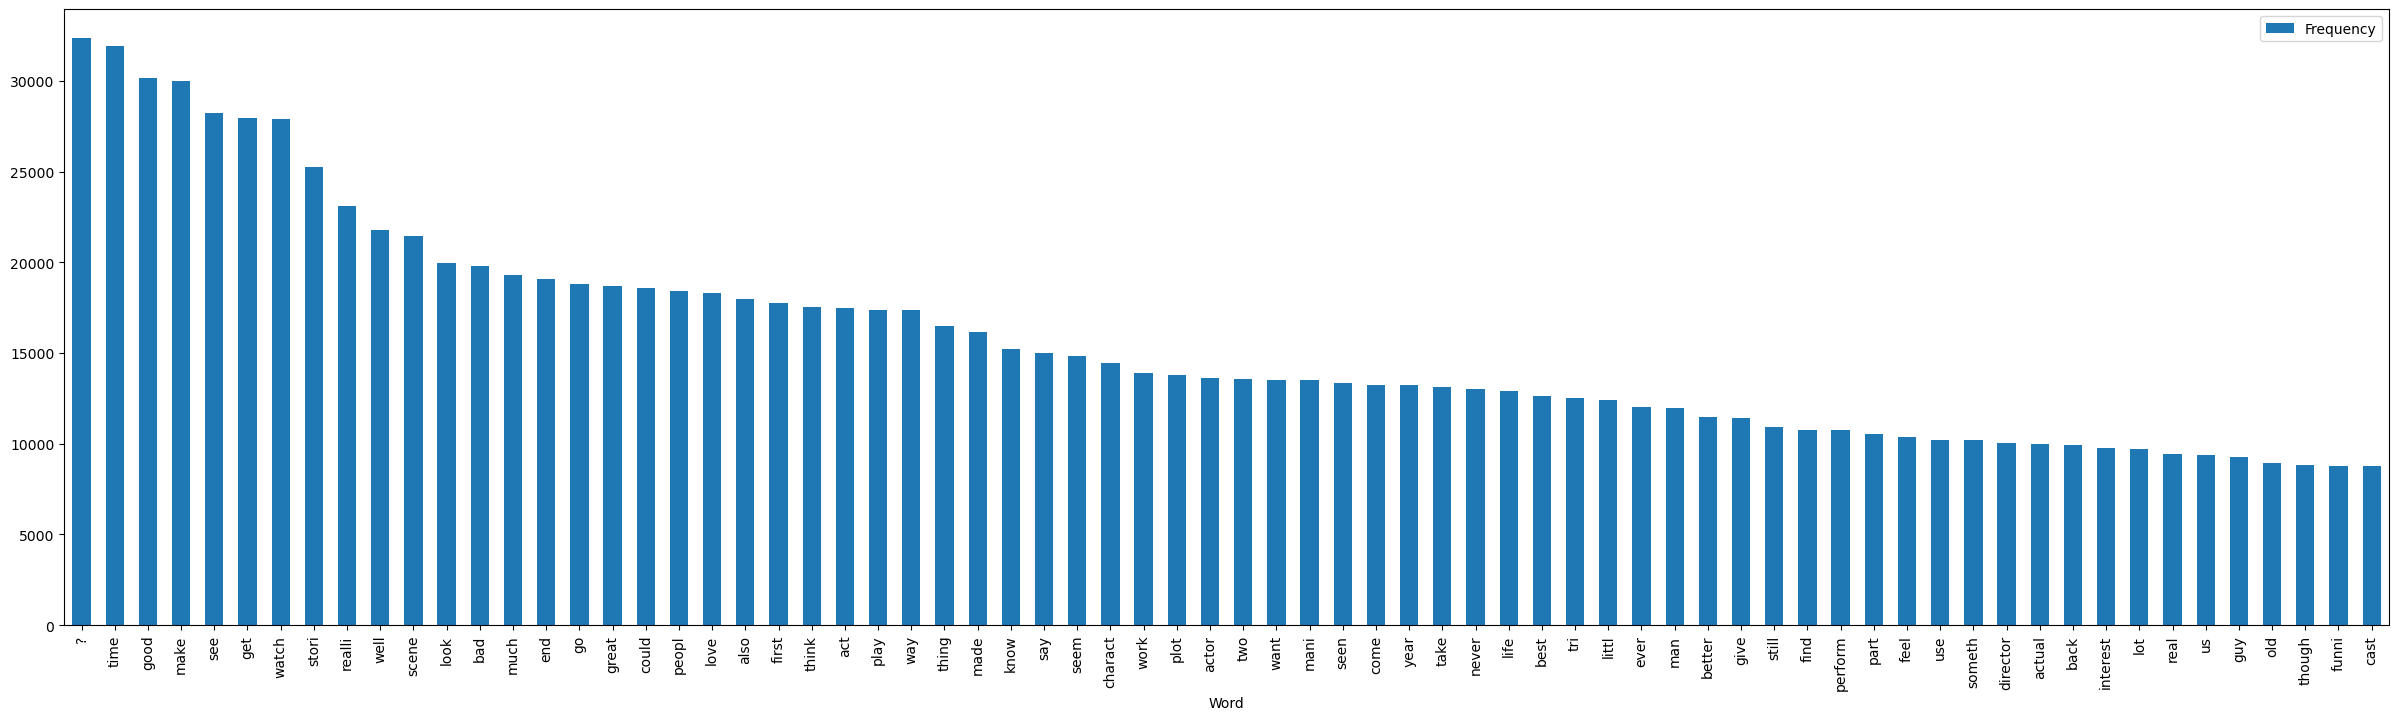

In [30]:
top_N = 70

words = (movies.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [31]:
rslt.transpose()

Word,?,time,good,make,see,get,watch,stori,realli,well,...,back,interest,lot,real,us,guy,old,though,funni,cast
Frequency,32336,31944,30180,30015,28233,27961,27868,25269,23089,21770,...,9947,9758,9720,9434,9383,9253,8933,8836,8764,8755


<h2><center> Visualize the positive and negative reviews as wordclouds </center></h2>


In [32]:
pos_string = ""
pos = movies.loc[movies.sentiment == 1, 'review']
for review in pos:
    pos_string += review
    pos_string += " "

neg_string = ""
neg = movies.loc[movies.sentiment == 0, 'review']
for review in neg:
    neg_string += review
    neg_string += " "

<center> <h2>Positve Reviews WordCloud</h2></center>


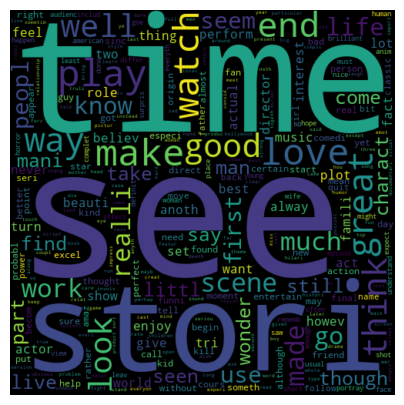

In [43]:
plt.figure(figsize=(5,5))
WC = WordCloud(width=500, height=500, max_words=1000, min_font_size=5)
positive_words = WC.generate(pos_string)
plt.imshow(positive_words,interpolation='bilinear')
plt.axis("off")
plt.show()

<center> <h2>Negative reviews WordCloud</h2></center>


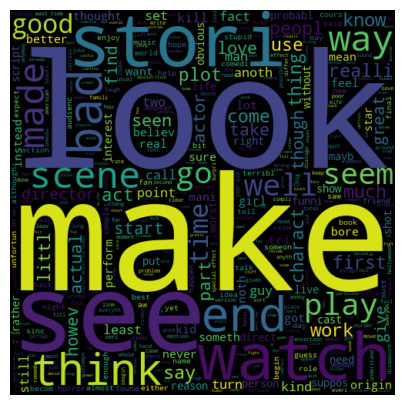

In [44]:
plt.figure(figsize=(5,5))
WC = WordCloud(width=500, height=500, max_words=1000, min_font_size=5)
negative_words = WC.generate(neg_string)
plt.imshow(negative_words,interpolation='bilinear')
plt.axis("off")
plt.show()

<center> <h2>Negative  reviews top 50 word frequency distribution</h2></center>


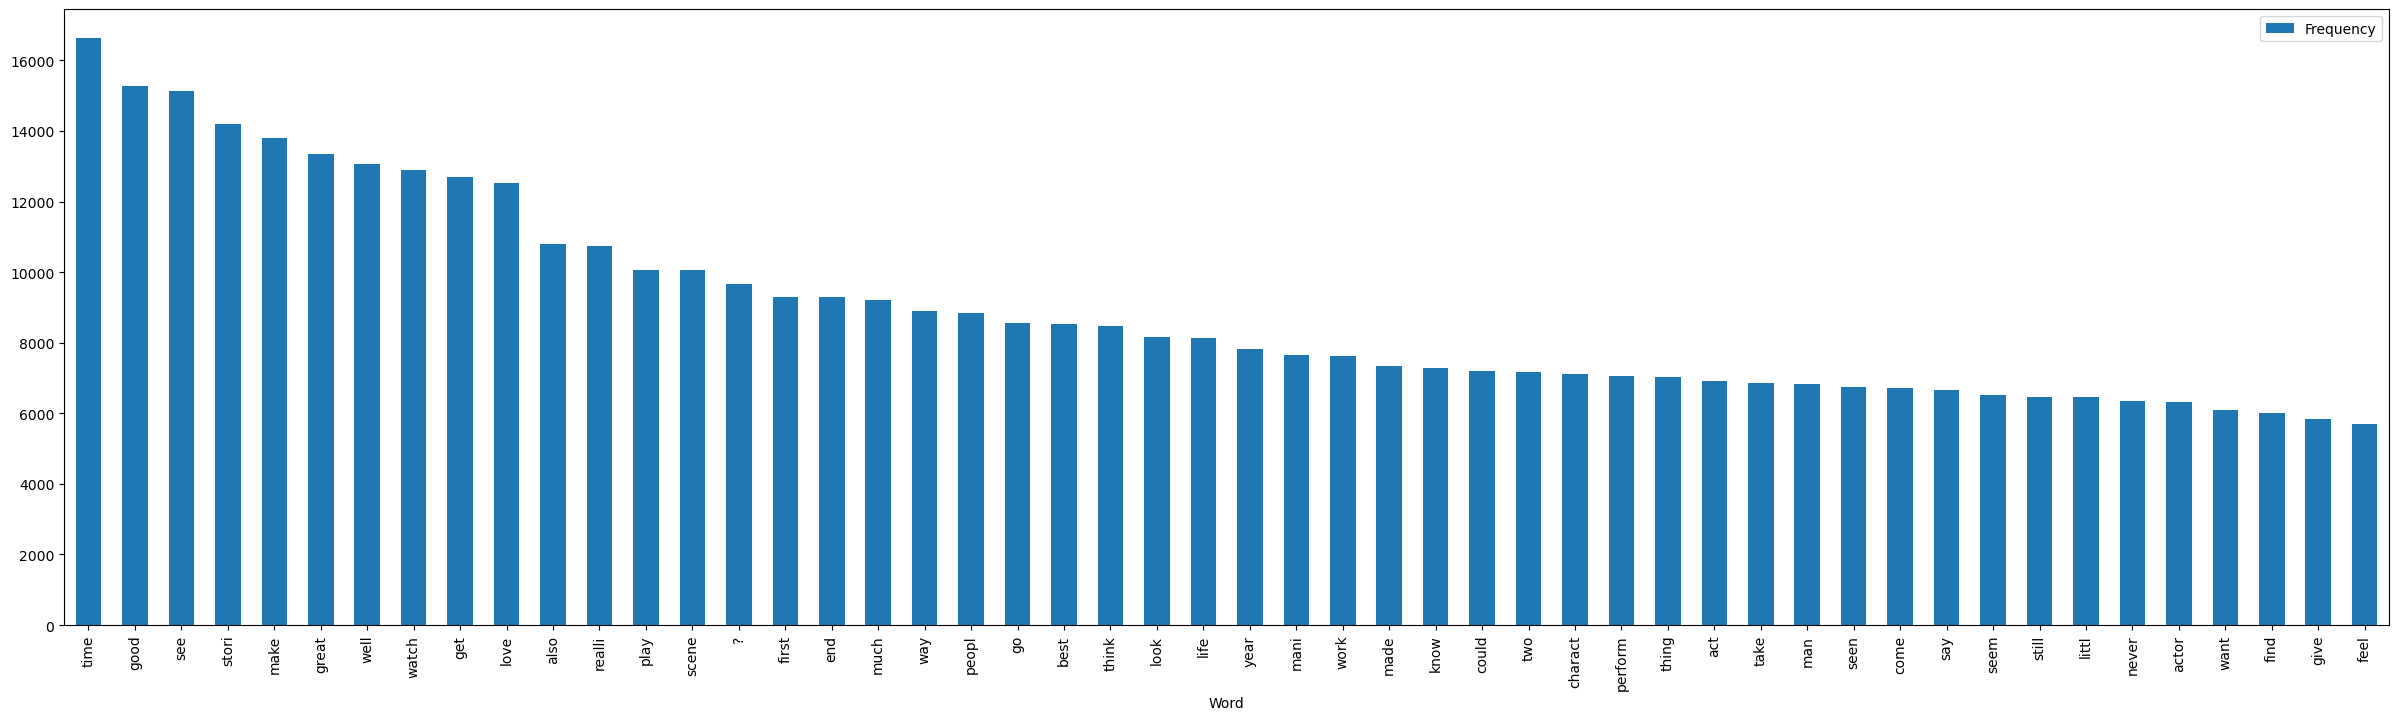

In [35]:
top_N = 50

words = (pos.str.cat(sep=' ').split())
pos_freq = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

pos_freq.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [36]:
pos_freq.transpose()

Word,time,good,see,stori,make,great,well,watch,get,love,...,say,seem,still,littl,never,actor,want,find,give,feel
Frequency,16620,15261,15133,14186,13808,13334,13064,12904,12693,12532,...,6657,6505,6460,6456,6344,6315,6093,5997,5840,5690


In [37]:
top_N = 50

words = (neg.str.cat(sep=' ').split())
neg_freq = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
neg_freq.transpose()

Word,?,make,bad,time,get,watch,good,see,realli,look,...,take,work,littl,actual,someth,noth,mani,love,guy,give
Frequency,22667,16207,15846,15324,15268,14964,14919,13100,12353,11774,...,6303,6260,5971,5938,5897,5893,5821,5785,5775,5596


* Character, show, ' 
* like, ! 
* time scene end
* make see



<center> <h2>Positve  reviews top 50 word frequency distribution</h2></center>


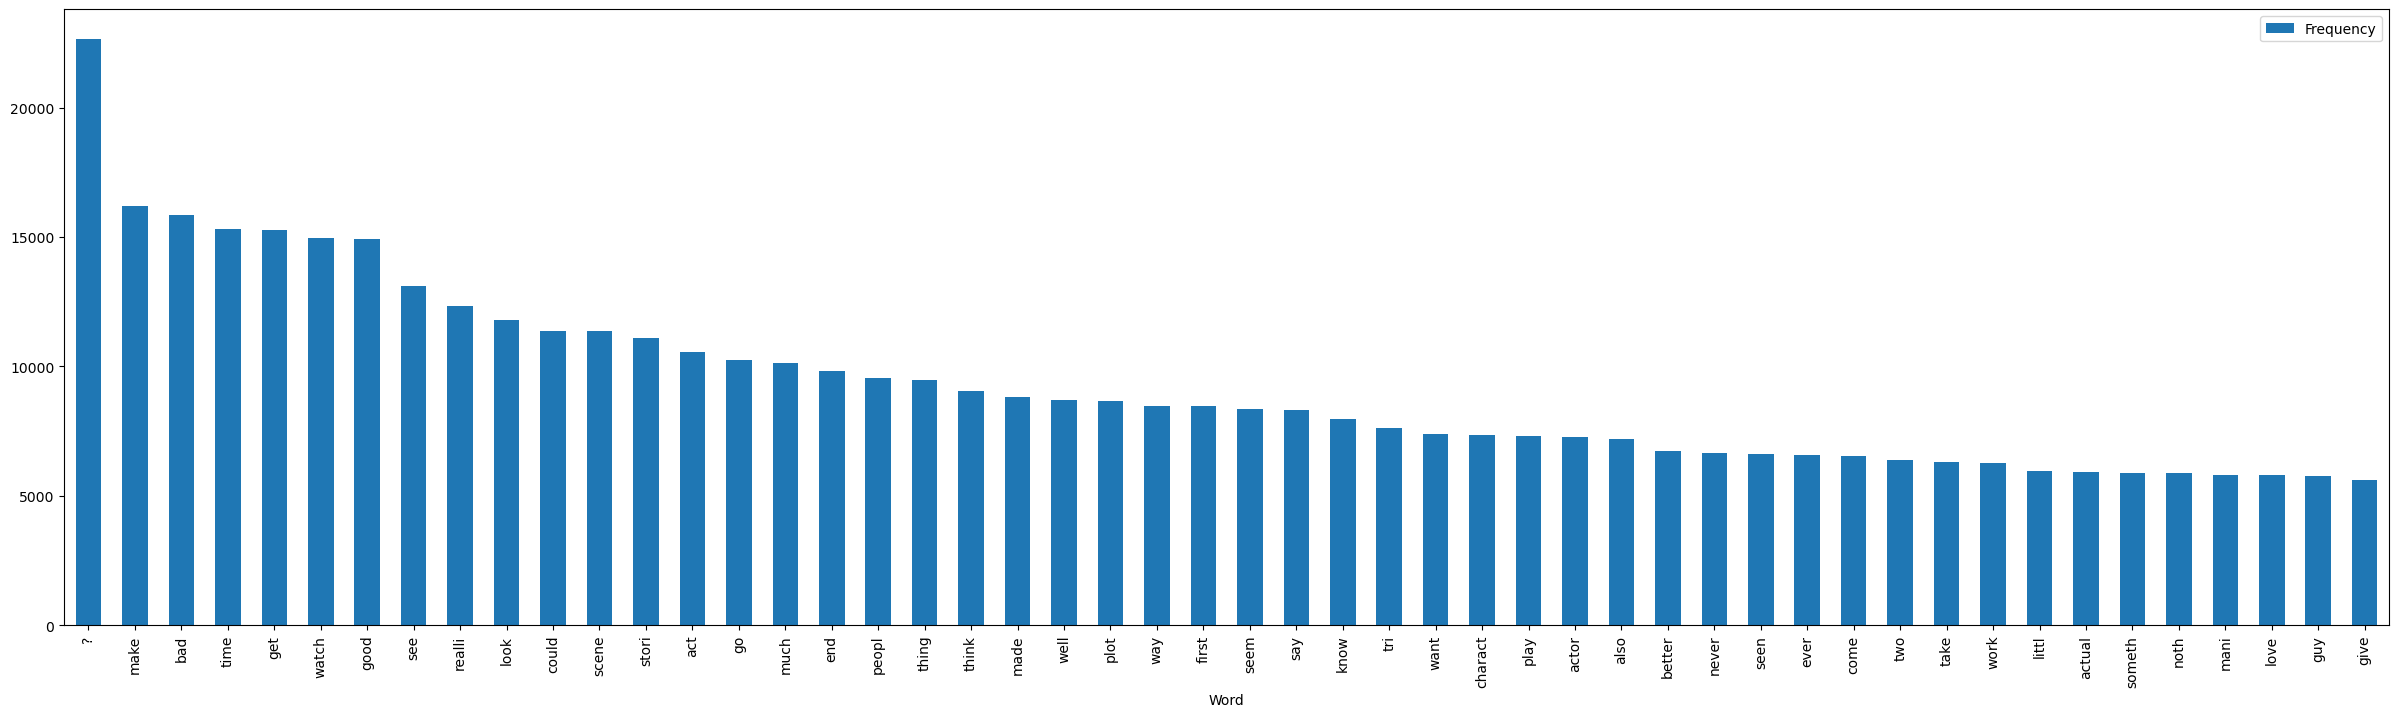

In [38]:
neg_freq.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

<center> <h2>Logarithmically scaled Frequency distribution of length of all movie Reviews</h2></center>


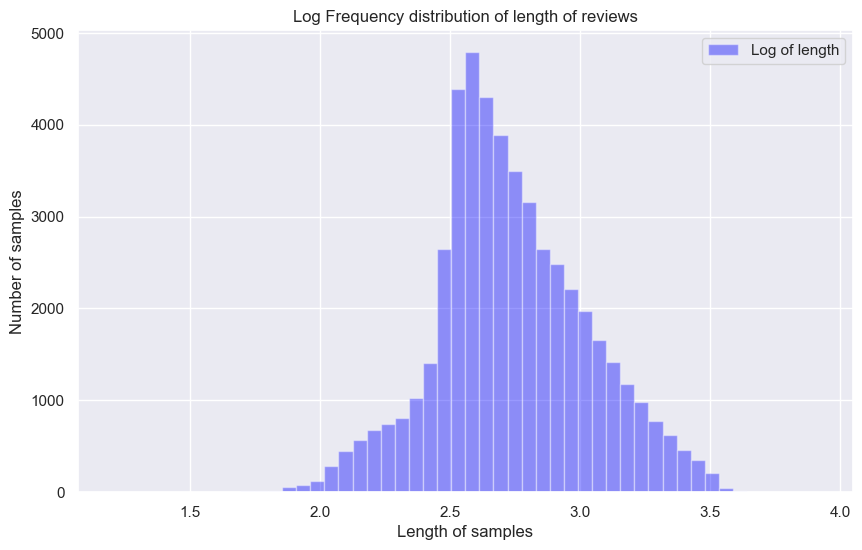

In [39]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(movies['review'])], 50, kde = False, 
             color = "blue", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of reviews')
plt.legend()
plt.show()

<center> <h2>Logarithmically scaled Frequency distribution of length of Positive Reviews</h2></center>


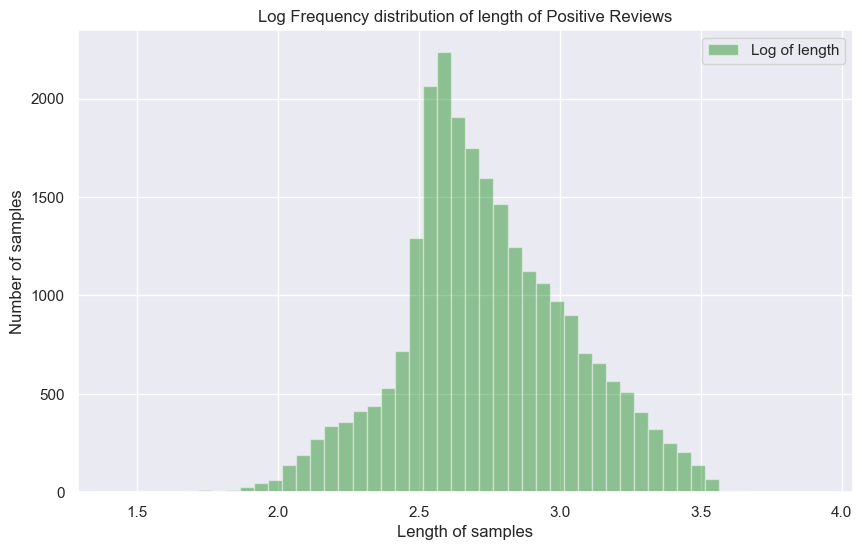

In [40]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(pos)], 50, kde = False, 
             color = "green", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of Positive Reviews')
plt.legend()
plt.show()

<center> <h2>Logarithmically scaled Frequency distribution of length of Negative Reviews</h2></center>


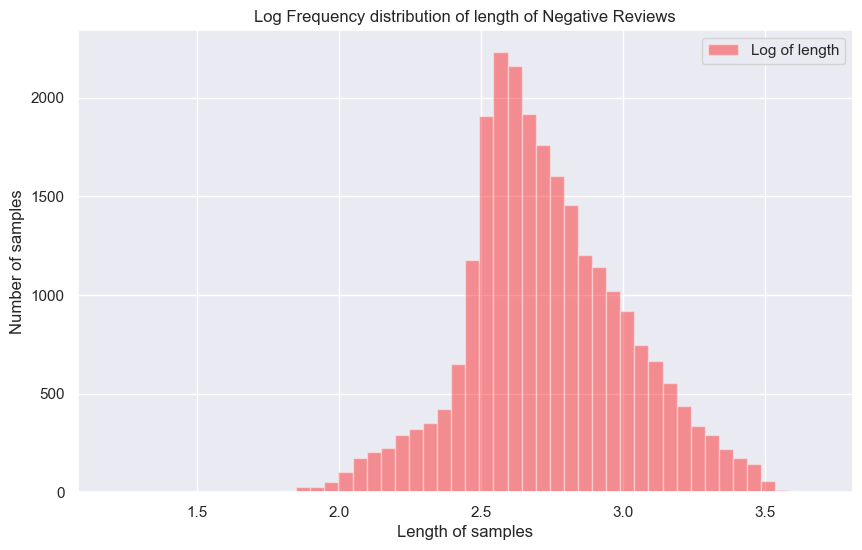

In [41]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(neg)], 50, kde = False, 
             color = "red", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of Negative Reviews')
plt.legend()
plt.show()

> **There is no significant difference in the length of positve and negative reviews**